# Pyocto + velest location

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal
import DasPrep as dp


# import pyproj


from nptdms import TdmsFile
import DasPrep as idas

# datapath = 'G:\\xfj_das\\'


# datapath = '/home/disk/disk02/bluo/xfj_das/'
# das_file = glob.glob(datapath+'*.tdms')
# das_file.sort()

# dp.read_das(das_file[0], metadata='True')



# Work Path

In [ ]:
DAS_DL_Dataset = lambda x: os.path.join("/home/disk/disk01/wzm/DAS_DL_Dataset", x)
workpath = DAS_DL_Dataset('data/xfj/das_event_reorganize/')
savefigpath = DAS_DL_Dataset('data/xfj/das_event_reorganize_fig/')
# savefigpath_refine = 'D:\\sustech_dir\\workdir\\das-event_reorganize_fig_2\\'
resave_npy_path = DAS_DL_Dataset('DASEventData/data/')

save_csv_path = DAS_DL_Dataset('DASEventData/phase_picks/')
eq_catalog_file = DAS_DL_Dataset('data/xfj/DetectedFinal.dat')

# catalog

In [14]:
eq_cat = pd.read_csv(eq_catalog_file, sep='\s+')


eq_time = np.array([datetime.datetime.strptime(str(eq_cat['Date'].values[i])+' '+str(eq_cat['Time'].values[i]), '%Y/%m/%d %H:%M:%S.%f') 
       for i in range(len(eq_cat))])
eq_cat = eq_cat.iloc[148:408]
print(eq_cat)

     #No.        Date          Time    Lat.     Lon.  Dep.  Mag.   Coef.  \
148     2  2022/04/28  06:28:38.622  23.860  114.504   7.2  0.10  0.9094   
149     3  2022/04/28  07:14:56.582  23.851  114.507   8.0 -0.20  0.6427   
150     4  2022/04/28  07:59:27.602  23.895  114.510   8.8 -0.54  0.3844   
151     5  2022/04/28  13:35:13.123  23.752  114.618  11.7  1.51  0.6814   
152     6  2022/04/28  14:32:30.004  23.851  114.507   8.0 -0.97  0.4414   
..    ...         ...           ...     ...      ...   ...   ...     ...   
403     6  2022/05/21  16:25:56.224  23.861  114.521   7.6 -0.92  0.4189   
404     7  2022/05/21  17:50:57.745  23.860  114.498   8.8  0.24  0.3703   
405     8  2022/05/21  19:22:27.005  23.854  114.502   8.8  0.85  0.5902   
406     9  2022/05/21  19:29:47.965  23.854  114.502   8.8  0.50  0.6350   
407    10  2022/05/21  21:10:48.125  23.755  114.546   6.3  0.20  1.0000   

     N(*MAD)     Reference  
148  49.6010  2.022043e+13  
149  38.1656  2.022043e+13  


## choose a event

In [26]:
iev = 149
eq_cat.iloc[iev]

#No.                            3
Date                   2022/05/11
Time                 05:08:33.381
Lat.                       23.862
Lon.                      114.484
Dep.                          7.6
Mag.                        -0.87
Coef.                      0.4468
N(*MAD)                    26.823
Reference    20220424235444.53125
Name: 297, dtype: object

Text(0, 0.5, 'Time (s)')

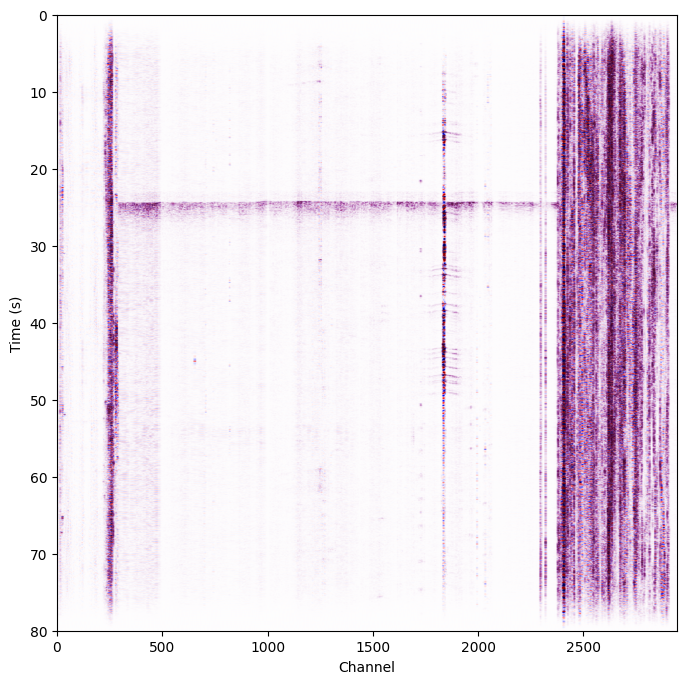

In [19]:
save_file_name_prefix = workpath + 'xfj_das_re_eq_'
savename = save_file_name_prefix + str(iev) + '.npy'
fq = 300
dt = 1./300.
data_raw = np.load(savename)
data_raw_d = signal.decimate(data_raw, 3, axis=-1).astype('float32')
dt *= 3
# data process
data_p = dp.das_preprocess(data_raw_d)
# f1, f2 = 15, 35
f1, f2 = 1,  20
data = dp.bandpass(data_p * signal.windows.tukey(data_p.shape[1], alpha=0.2), dt, fl=f1, fh=f2)
clim = data.std() *3
fig = plt.figure(figsize=[8,8])
plt.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

plt.xlabel('Channel')
plt.ylabel('Time (s)')

# Manual Label

(30.0, 20.0)

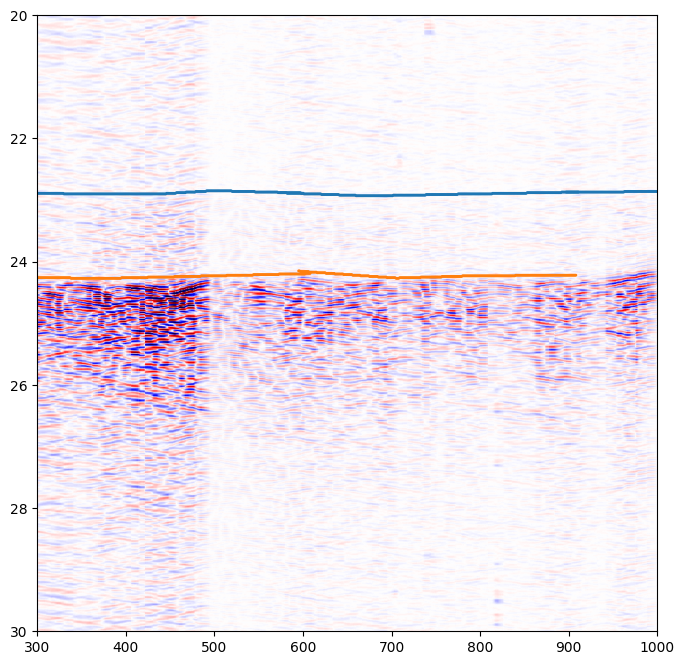

In [24]:
manual_picks = pd.read_csv( DAS_DL_Dataset(f"DASEventData/phase_picks/xfj_das_100Hz_{iev}.csv") , sep=',',header=None, names=["channel_index","phase_index","phase_time","phase_score","phase_type"])
color = manual_picks["phase_type"].map({"P": "C0", "S": "C1"})
fig = plt.figure(figsize=[8,8])
plt.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])
plt.scatter(manual_picks["channel_index"].values, manual_picks["phase_index"].values * dt, c=color, s=1)
plt.scatter([], [], c="r", label="P")
plt.scatter([], [], c="b", label="S")
plt.xlim(300,1000)
plt.ylim(30,20)


# Model results

In [22]:

diting_event = pd.read_csv("/home/wuzm/data/DAS_DL_Dataset/data/xfj/sac_diting/xfj_das_re_eq_" + str( iev ) + ".xfj.DAS._P_S.txt" , sep='\s+',header=None, names=['sta','chn','P0','P1','S0','S1'])


652
2022-04-28 07:15:19+00:00
2022-04-28 07:15:20+00:00
585
2022-04-28 07:14:56.582000
22.952991452991455


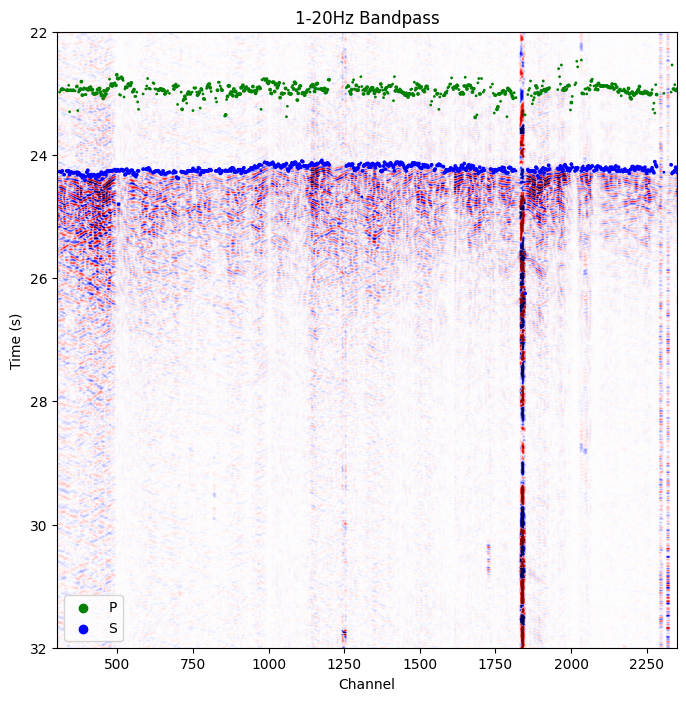

In [23]:
print(len(diting_event))
def get_phase_df(detect_event , phase , freq = '1s'):
    detect_event['P'] = pd.to_datetime(diting_event['P0'])
    detect_event['S'] = pd.to_datetime(diting_event['S0'])
    grouping = detect_event.groupby(pd.Grouper(key=phase , freq = freq))
    count = detect_event.groupby(pd.Grouper(key=phase , freq = freq)).count().reset_index()
    p1 = count.sort_values(by='sta' , ascending=False).reset_index().loc[0,phase]
    print(p1)
    return grouping.get_group(p1).reset_index()
P_df = get_phase_df(diting_event , 'P')
S_df = get_phase_df(diting_event , 'S')

diting_event = pd.merge(P_df, P_df, how='inner')
print(len(diting_event))

start_time = eq_time[iev]
print(start_time)
fig = plt.figure(figsize=[8,8])
plt.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])
plt.xlabel('Channel')
plt.ylabel('Time (s)')
p_time = np.array([datetime.datetime.strptime(diting_event["P0"][i], '%Y-%m-%dT%H:%M:%S.%fZ').__sub__(start_time)
       for i in range(len(diting_event))])
s_time = np.array([datetime.datetime.strptime(diting_event["S0"][i], '%Y-%m-%dT%H:%M:%S.%fZ').__sub__(start_time)
       for i in range(len(diting_event))])
p_s = np.array([i.seconds + i.microseconds /1000000. for i in p_time])
s_s = np.array([i.seconds + i.microseconds /1000000. for i in s_time])

p_c = np.array([3 if i >0.6 else 1 for i in diting_event['P1']])
s_c = np.array([3 if i >0.6 else 1 for i in diting_event['S1']])

print(np.mean(p_s))
plt.scatter(diting_event["chn"].values,p_s, c="g", s=p_c)
plt.scatter(diting_event["chn"].values,s_s, c="b", s=s_c)
plt.scatter([], [], c="g", label="P")
plt.scatter([], [], c="b", label="S")

# for i in range(len(p_s)):
#     if np.abs(p_s[i]-np.mean(p_s)) > 10:
#        if s_c[i]>0:
#               print(diting_event['S1'][i])
#               plt.annotate(diting_event['S1'][i], xy = (diting_event["chn"][i], p_s[i]))
plt.legend()
# plt.xlabel("Distance (m)")
# plt.ylabel("Time (s)")
# plt.ylim(int(np.mean(s_s)+5),int(np.mean(p_s)-5))
plt.ylim(32,22)
plt.xlim(300 , 2350)

arglist = ['Date', 'Time', 'Lat.', 'Lon.', 'Mag.', 'Dep.']

# plt.text(2050, 75 ,  eq_cat.iloc[iev][arglist])
plt.title("1-20Hz Bandpass")
plt.show()

In [ ]:
import pyocto
# region = "chile"
# region = "xfj"
# test = "local_2"
# DiTingProject_dir = "/home/wzm/Desktop/data/DiTingProject/"
# data_path = lambda x: os.path.join(f"{DiTingProject_dir}results/xfj23km/location/pyocto/data/all_event_unclean/", x)
# result_path = f"{DiTingProject_dir}results/xfj23km/location/pyocto/results/{test}"
# if not os.path.exists(result_path):
#     os.makedirs(result_path)
# result_path = lambda x: os.path.join(f"{DiTingProject_dir}results/xfj23km/location/pyocto/results/{test}", x)
# figure_dir = lambda x: os.path.join(f"{DiTingProject_dir}results/xfj23km/location/pyocto/results/{test}", x)


array([[ 235.        ,   23.91989211,  114.4572046 ,  116.67897253],
       [ 236.        ,   23.91989031,  114.45719591,  116.55034077],
       [ 237.        ,   23.91988934,  114.4571864 ,  116.41717958],
       ...,
       [2250.        ,   23.91723414,  114.46113178,   97.21511486],
       [2251.        ,   23.91723986,  114.46113916,   97.19010916],
       [2252.        ,   23.91724558,  114.46114655,   97.16510345]],
      shape=(2018, 4))

In [ ]:
# picks = pd.read_csv("/media/wzm/HLPBook/DiTingProject/results/xfj23km/location/GaMMa/data/event6/diting_arrival_cat.csv")
# stations = pd.read_csv("/media/wzm/HLPBook/DiTingProject/results/xfj23km/XFJ_station_Chn_interp_23km_4m.csv")

region = "xfj"
event_name = glob.glob(f"{DiTingProject_dir}results/xfj23km/location/xfj_diting_event_amp/*txt")
diting_new_pd_list = []
for event in event_name:
    diting_event = pd.read_csv(event,  sep='\s+',header=None, names=['sta','chn','P0','P1','P_SNR' , 'P_AMP','S0','S1', 'S_SNR' , 'S_AMP'])
    filter = True
    if len(diting_event) <= 0 :
         continue
    if filter: 
        
        def get_phase_df(detect_event , phase , freq = '5s'):
            detect_event['P'] = pd.to_datetime(detect_event['P0'])
            detect_event['S'] = pd.to_datetime(detect_event['S0'])
            grouping = detect_event.groupby(pd.Grouper(key=phase , freq = freq))
            count = detect_event.groupby(pd.Grouper(key=phase , freq = freq)).count().reset_index()
            p1 = count.sort_values(by='sta' , ascending=False).reset_index().loc[0,phase]
            print(p1)
            return grouping.get_group(p1).reset_index()
        P_df = get_phase_df(diting_event , 'P')
        S_df = get_phase_df(diting_event , 'S')

        diting_event = pd.merge(P_df, P_df, how='inner')
        print(len(diting_event))

        
    else:
        diting_event['P'] = pd.to_datetime(diting_event['P0'])
        diting_event['S'] = pd.to_datetime(diting_event['S0'])
    d_p = diting_event.drop(columns=['S0','S1','S' , 'P0' , 'S_SNR' , 'S_AMP'], axis=1)
    # print(d_p.dtypes)
    d_p.rename(columns={'sta':'sta','chn': 'station_id','P' : 'phase_time', 'P1' : 'phase_score' , 'P_SNR': 'SNR' , 'P_AMP': 'phase_amplitude'},inplace = True) # channel_index,phase_index,phase_time,phase_score,phase_type
    d_p['phase_type'] = 'P'
    # print(d_p.dtypes)
    d_s = diting_event.drop(columns=['P0','P1','P',"S0" , 'P_SNR' , 'P_AMP' ])
    d_s.rename(columns={'sta':'sta','chn': 'station_id','S' : 'phase_time', 'S1' : 'phase_score','S_SNR': 'SNR' , 'S_AMP': 'phase_amplitude'},inplace = True)# channel_index,phase_index,phase_time,phase_score,phase_type
    d_s['phase_type'] = 'S'
    diting_new_pd = pd.merge( d_p , d_s,how = 'outer' )
    if len(diting_new_pd) == 0:
        continue
    picks = diting_new_pd
    picks['station_id'] = ["CH-"+str(i) for i in  picks['station_id']]
    # print(picks.head(5))
    stations = pd.read_csv("/media/wzm/HLPBook/DiTingProject/results/xfj23km/XFJ_station_Chn_interp_23km_4m.csv", sep=',')
    stations = df = pd.DataFrame(np.load("/home/disk/disk01/wzm/DAS_DL_Dataset/data/xfj/xfj_ch_loc.npy"), columns=['channl', '', 'C'])
    stations['station_id'] = [ "CH-"+str(int(i.split('-')[1])) for i in stations['channel'] ]
    stations['elevation_m'] = 100
    # print(picks['station_id'].dtypes)
    # print(picks.head(4))
    # print(len(picks),len(stations))
    picks = picks.loc[ picks['station_id'].map(lambda x:x in stations['station_id'].values)  ]
    stations = stations.loc[ stations['station_id'].map(lambda x:x in picks['station_id'].values)  ]
    print(len(picks),len(stations))

    
    picks.rename(columns={"station_id": "station", "phase_time": "time", "phase_type": "phase", "phase_score": "prob", "phase_amplitude": "phase_amplitude"}, inplace=True)
    stations.rename(columns={"station_id": "id", "elevation_m": "elevation"}, inplace=True)
    velocity_model = pyocto.VelocityModel0D(
    p_velocity=6.2,
    s_velocity=3.54,
    tolerance=2,
        )
    associator = pyocto.OctoAssociator.from_area(
    # lat=(21, 25),
    # lon=(110, 120),
    lat=(23.7, 23.9),
    lon=(114.6, 114.7),
    zlim=(0, 10),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
        )
    associator.transform_stations(stations)
    picks["time"] = pd.to_datetime(picks["time"])
    picks["time"] = picks["time"].apply(lambda x: x.timestamp())
    events, assignments = associator.associate(picks, stations)
    associator.transform_events(events)
    if len(events) > 0:
        events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
        events.to_csv(result_path("pyocto_associate_cat.csv"),index=False,sep=',',mode='a+',header=False)
        associate_list = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
        associate_list.to_csv(result_path(event.split("/")[-1][:-4]+".csv"),index = False,sep=',')
stations.to_csv(result_path("stations.csv"), index=False)